In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/raf-db-dataset


In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [12]:
import os

train_dir = '/kaggle/input/raf-db-dataset/DATASET/train'  # путь к папке с датасетов

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Проверяем, что это папка
        num_images = len(os.listdir(class_path))
        print(f'Класс {class_name}: {num_images} изображений')

Класс 7: 2524 изображений
Класс 2: 281 изображений
Класс 5: 1982 изображений
Класс 3: 717 изображений
Класс 1: 1290 изображений
Класс 4: 4772 изображений
Класс 6: 705 изображений


In [13]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.1
)

In [14]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224), # Размер изображения
    color_mode="rgb",
    batch_size=batch_size,  # Количество изображений в одном батче
    class_mode='categorical', # Многоклассовая классификация
    subset="training",  # Обучающий набор
    shuffle=True  # Перемешивание данных
)

val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation",  # Валидационный набор
    shuffle=False
)

Found 11046 images belonging to 7 classes.
Found 1225 images belonging to 7 classes.


In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D
batch_size = 64
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Добавьте пользовательские слои классификации сверху
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
LEARNING_RATE = 0.0001
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // train_set.batch_size,
    epochs=5,
    validation_data=val_set,
    validation_steps=val_set.samples // val_set.batch_size,
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 308s 716ms/step - accuracy: 0.5212 - loss: 1.3181 - val_accuracy: 0.2048 - val_loss: 1.8712
Epoch 2/5
  1/345 ━━━━━━━━━━━━━━━━━━━━ 1:43 300ms/step - accuracy: 0.6562 - loss: 1.0503

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


345/345 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.6562 - loss: 1.0503 - val_accuracy: 0.2015 - val_loss: 1.8736
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 202s 585ms/step - accuracy: 0.7378 - loss: 0.7401 - val_accuracy: 0.4186 - val_loss: 1.5411
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7500 - loss: 0.7386 - val_accuracy: 0.4038 - val_loss: 1.5436
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 229s 534ms/step - accuracy: 0.7929 - loss: 0.5755 - val_accuracy: 0.7377 - val_loss: 0.7240


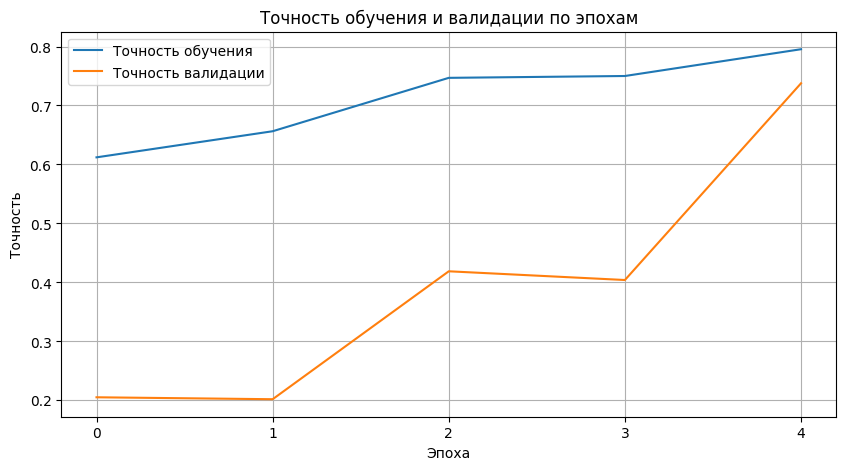

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Точность обучения')
    plt.plot(history.history['val_accuracy'], label='Точность валидации')
    plt.title('Точность обучения и валидации по эпохам')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)

Тюнинг

In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))



# #разморозка  30% слоев базовой модели
# fine_tune_at = int(len(base_model.layers) * 0.7)
# for layer in base_model.layers[fine_tune_at:]:
#     layer.trainable = True

batch_size = 32
# Добавьте пользовательские слои классификации сверху
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
LEARNING_RATE = 0.0001
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Обратные вызовы для ранней остановки и сохранения лучшей модели
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("model_checkpoint.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [36]:
# Обратные вызовы для ранней остановки и сохранения лучшей модели
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("model_checkpoint.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [37]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 24,060,935 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [38]:
history = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // train_set.batch_size,
    epochs=20,
    validation_data=val_set,
    validation_steps=val_set.samples // val_set.batch_size,
    callbacks=callbacks
)

Epoch 1/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 273s 634ms/step - accuracy: 0.5161 - loss: 1.3479 - val_accuracy: 0.1998 - val_loss: 1.9922 - learning_rate: 1.0000e-04
Epoch 2/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.7188 - loss: 1.0414 - val_accuracy: 0.1998 - val_loss: 1.9867 - learning_rate: 1.0000e-04
Epoch 3/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 222s 644ms/step - accuracy: 0.7242 - loss: 0.7829 - val_accuracy: 0.4975 - val_loss: 1.3897 - learning_rate: 1.0000e-04
Epoch 4/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.7188 - loss: 0.6455 - val_accuracy: 0.5058 - val_loss: 1.3665 - learning_rate: 1.0000e-04
Epoch 5/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 196s 567ms/step - accuracy: 0.7781 - loss: 0.6399 - val_accuracy: 0.7204 - val_loss: 0.8141 - learning_rate: 1.0000e-04
Epoch 6/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.8438 - loss: 0.3616 - val_accuracy: 0.7064 - val_loss: 0.8244 - learning_rate: 1.0000e-04
Epoch 7/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 216s 6

In [39]:
model.save("ResNet50.keras")

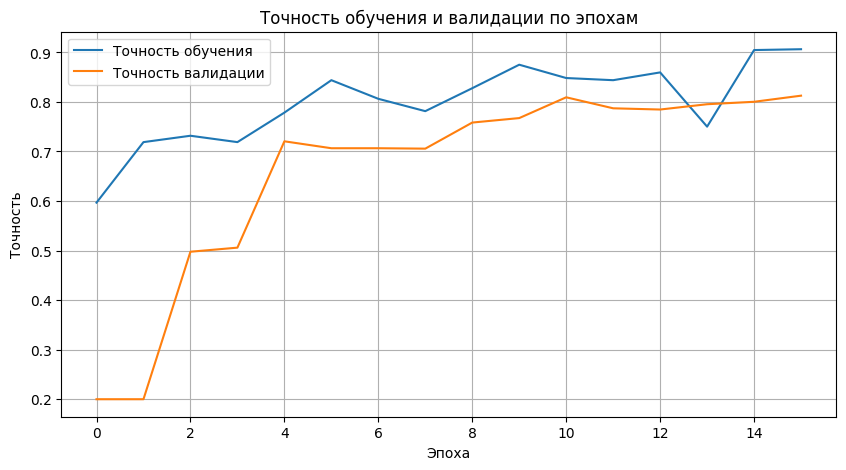

In [40]:
plot_accuracy(history)

In [42]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import os

data = '/kaggle/input/raf-db-dataset/DATASET/train'
model = load_model('ResNet50.keras')

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img


classes = ['Удивление', 'Страх', 'Отвращение', 'Счастливый', 'Грустно', 'Злой', 'Нейтрально']
folders = ['1', '2', '3', '4', '5', '6', '7']
folder_to_class = {name: i for i, name in enumerate(folders)}

correct = [0] * len(classes)
total = [0] * len(classes)

for folder in folders:
    true_class = folder_to_class[folder]
    folder_path = os.path.join(data, folder)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = preprocess_image(img_path)

        pred = model.predict(img, verbose=0)
        predicted_class = np.argmax(pred)

        if predicted_class == true_class:
            correct[true_class] += 1
        total[true_class] += 1

print("Точность по классам:")
for i, class_name in enumerate(classes):
    if total[i] > 0:
        accuracy = (correct[i] / total[i]) * 100
        print(f"{class_name}: {accuracy:.2f}%")
    else:
        print(f"{class_name}: Нет данных")


Точность по классам:
Удивление: 91.09%
Страх: 74.38%
Отвращение: 74.06%
Счастливый: 96.21%
Грустно: 79.41%
Злой: 84.11%
Нейтрально: 90.53%
